<a href="https://colab.research.google.com/github/Nanashi-bot/autoencoder/blob/main/VAEMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations (e.g., convert to tensor)
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)

# Create DataLoader for batching
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18381050.11it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 533071.47it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 970580.86it/s] 


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1478848.69it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [2]:
# Example: Display the shape of the first batch
images, labels = next(iter(train_loader))
print(images.shape)  # (64, 1, 28, 28) -> 64 samples, 1 channel (grayscale), 28x28 size
print(labels.shape)  # (64,) -> 64 labels

torch.Size([64, 1, 28, 28])
torch.Size([64])


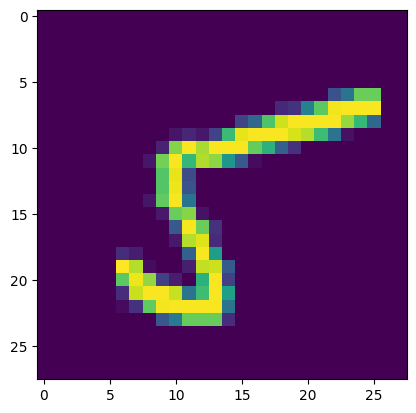

In [3]:
import matplotlib.pyplot as plt
plt.imshow(images[1].permute(1, 2, 0))

In [4]:
import torch.nn as nn
import torch.optim as optim

In [5]:
# Assuming 2 is the number of latent dimensions and 256 hidden dimensions

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
        )
        self.z_mean = nn.Linear(256, 2)
        self.z_log_var = nn.Linear(256, 2)
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return h

    def decode(self, z):
        h = self.decoder(z)
        return h

    def reparameterize(self, mu, logvar):
        # For standard deviation
        std = torch.exp(0.5 * logvar)
        # For random noise
        eps = torch.randn_like(std)
        return mu + eps * std # For reparameterization

    def forward(self, x):
        h = self.encode(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        z = self.reparameterize(z_mean, z_log_var)
        return self.decode(z), z_mean, z_log_var

In [6]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

In [7]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [8]:
def train(model, train_loader, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.view(data.size(0), -1)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}')

In [9]:
train(model, train_loader, optimizer, num_epochs)

Epoch [1/10], Loss: 184.5140
Epoch [2/10], Loss: 165.6079
Epoch [3/10], Loss: 162.8839
Epoch [4/10], Loss: 161.2742
Epoch [5/10], Loss: 160.0792
Epoch [6/10], Loss: 159.0434
Epoch [7/10], Loss: 158.1464
Epoch [8/10], Loss: 157.3614
Epoch [9/10], Loss: 156.6252
Epoch [10/10], Loss: 156.0071


In [73]:
num_epochs = 5

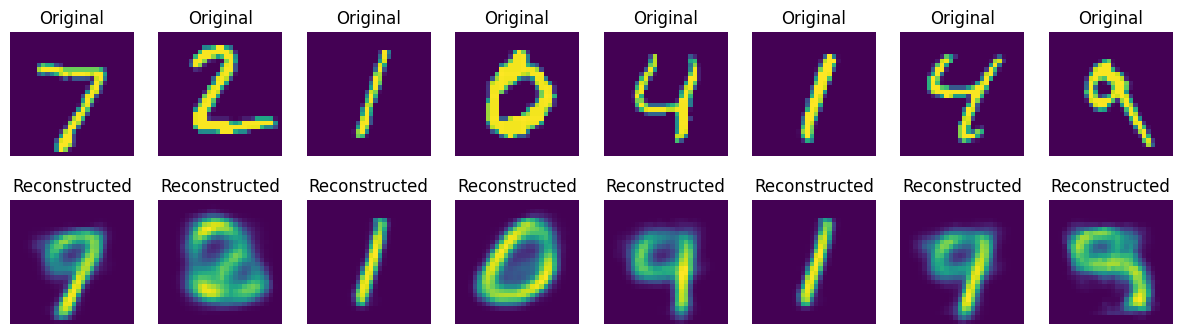

In [22]:
def check_reconstruction(model, test_loader):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1)  # Flatten images
            recon_batch, _, _ = model(data)  # Get the reconstructed images

            # Show the original and reconstructed images
            n = 8
            comparison = torch.cat([data[:n], recon_batch[:n]])
            comparison = comparison.view(-1, 1, 28, 28)  # Reshape for plotting
            # Plotting
            fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(15, 4))
            for i in range(n):
                axes[0, i].imshow(comparison[i].cpu().numpy().squeeze())
                axes[0, i].set_title("Original")
                axes[0, i].axis('off')

                axes[1, i].imshow(comparison[n + i].cpu().numpy().squeeze())
                axes[1, i].set_title("Reconstructed")
                axes[1, i].axis('off')

            plt.show()
            break

check_reconstruction(model, test_loader)